# Data Preprocessing

In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from scipy.stats import skew, boxcox
from scipy import sparse
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, preprocessing
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [29]:
train_label = pd.read_csv('../ProjectFiles/File1.csv')
train_label_size = train_label.shape[0]
train = pd.read_csv('../ProjectFiles/File2.csv')
train_size = train.shape[0]
test = pd.read_csv('../ProjectFiles/File3.csv')
test_size = test.shape[0]

In [30]:
print('File 1:', train_label_size, 'survey responses')
print('File 2:', train_size, 'available features')
print('File 3:', test_size, 'submission records')

File 1: 20000 survey responses
File 2: 20000 available features
File 3: 29231 submission records


In [31]:
df_test = pd.concat([test,train], axis=1)
df_test = df_test.loc[:,~df_test.columns.duplicated()]
df_test.shape

(29231, 149)

In [32]:
df_full = pd.concat([df_test,train_label], axis=1)
df_full = df_full.loc[:,~df_full.columns.duplicated()]
df_full.shape

(29231, 150)

This is a binary classification problem. For values in SPENDINGRESPONSE, if it is "Spend to Improve Economy", we replace it to be "1". For the "Reduce National Debt and Deficit", we use "0" to represent it. 

In [33]:
df_full.SPENDINGRESPONSE.replace(["Spend to Improve Economy","Reduce National Debt and Deficit"], [1,0], inplace=True)

In [34]:
df_full.head()

,ID,State,f1,f2,f3,f4,f5,f6,f7,f8,...,f139,f140,f141,f142,f143,f144,f145,f146,f147,SPENDINGRESPONSE
0,3094,AK,AK01,69,E,61.0,55.33333,66.0,52.33333,49.25,...,3.0,3.0,4.0,4.0,7.0,4.0,1.0,1.0,NaN,1.0
1,13856,AK,AK01,59,M,61.0,55.33333,66.0,52.33333,49.25,...,6.0,9.0,9.0,5.0,7.0,8.0,4.0,4.0,NaN,1.0
2,16213,AK,AK01,63,D,61.0,55.33333,66.0,52.33333,49.25,...,6.0,6.0,9.0,7.0,2.0,6.0,1.0,1.0,NaN,0.0
3,17196,AK,AK01,55,D,61.0,55.33333,66.0,52.33333,49.25,...,6.0,4.0,2.0,1.0,6.0,6.0,3.0,2.0,NaN,0.0
4,17762,AK,AK01,75,D,61.0,55.33333,66.0,52.33333,49.25,...,4.0,1.0,1.0,1.0,3.0,3.0,0.0,0.0,NaN,0.0


In [35]:
df_full.tail()

,ID,State,f1,f2,f3,f4,f5,f6,f7,f8,...,f139,f140,f141,f142,f143,f144,f145,f146,f147,SPENDINGRESPONSE
29226,1458261719,WY,WY01,64,M,81.75,78.75,75.66666,90.58334,89.66666,...,0.0,7.0,8.0,9.0,5.0,8.0,1.0,3.0,NaN,NaN
29227,1458264361,WY,WY01,58,M,81.75,78.75,75.66666,90.58334,89.66666,...,7.0,8.0,8.0,9.0,9.0,7.0,4.0,3.0,NaN,NaN
29228,1458272612,WY,WY01,80,M,81.75,78.75,75.66666,90.58334,89.66666,...,6.0,4.0,3.0,9.0,4.0,5.0,4.0,0.0,NaN,NaN
29229,1623671361,WY,WY01,41,M,81.75,78.75,75.66666,90.58334,89.66666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
29230,2017388246,WY,WY01,40,E,81.75,78.75,75.66666,90.58334,89.66666,...,1.0,4.0,9.0,7.0,6.0,9.0,3.0,6.0,NaN,NaN


In [36]:
df_full.SPENDINGRESPONSE[20000:].isnull().sum()

9231

In [37]:
train = df_full[:20000]
train.shape

(20000, 150)

In [38]:
test = df_full[20000:]
test.shape

(9231, 150)

Train and test data are merged into dataframe df_full, where the last 9231 rows have no SPENDINGRESPONSE labels.

## Group features

In this step, we group the features into catigorical and numerical features, so that we can preprocess them seperately later. Notice that features are anonymous and all encoded, only limited feature engineering can be done. 

In [39]:
data_types = df_full.dtypes  
cat_cols = list(data_types[data_types=='object'].index)
con_cols = list(data_types[data_types=='int64'].index) + list(data_types[data_types=='float64'].index)

id_col = 'ID'
target_col = 'SPENDINGRESPONSE'
con_cols.remove('ID')
con_cols.remove('SPENDINGRESPONSE')

print("# of Categorical features:", len(cat_cols))
print("Categorical features:", cat_cols)
print("# of Numerical features:", len(con_cols))
print("Numerical features:", con_cols)
print("ID: %s, target: %s" %( id_col, target_col))

# of Categorical features: 24
Categorical features: ['State', 'f1', 'f3', 'f12', 'f13', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f108', 'f110', 'f114', 'f115', 'f118', 'f119', 'f120', 'f121', 'f122', 'f126']
# of Numerical features: 124
Numerical features: ['f2', 'f93', 'f94', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f104', 'f105', 'f106', 'f107', 'f109', 'f111', 'f112', 'f113', 'f116', 'f117', 'f123', 'f12

## Data Exploration

Pattern difference of training and testing data

Count plot for categorical features in a 6x4 grid.

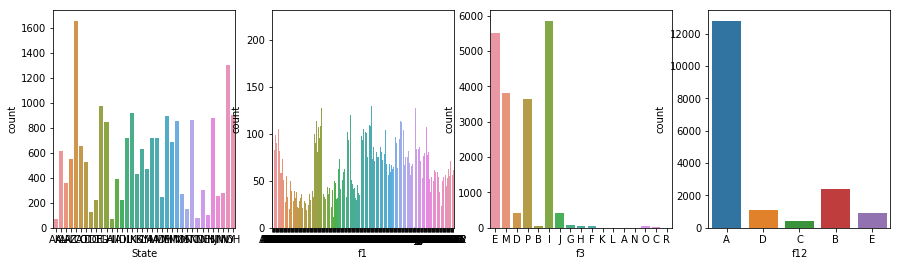

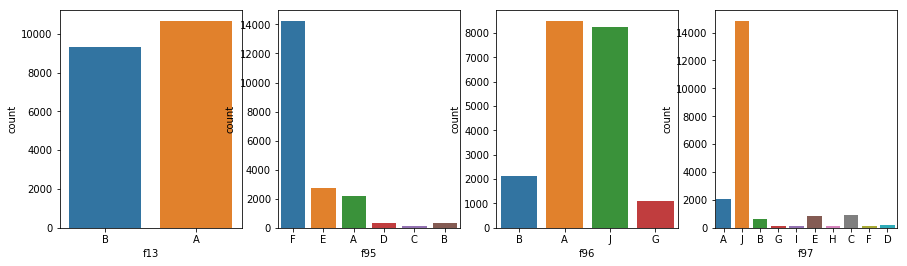

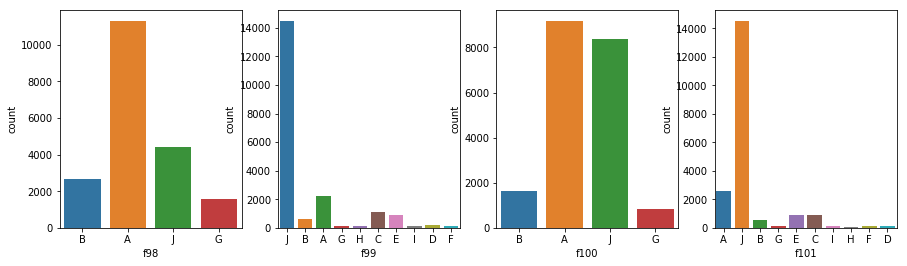

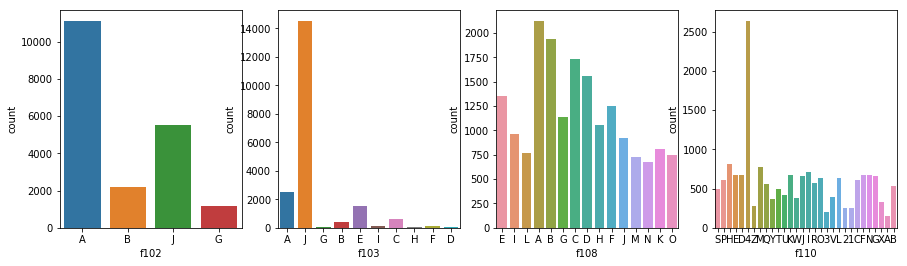

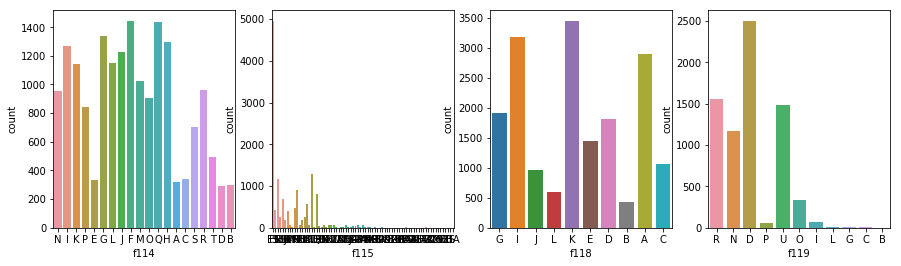

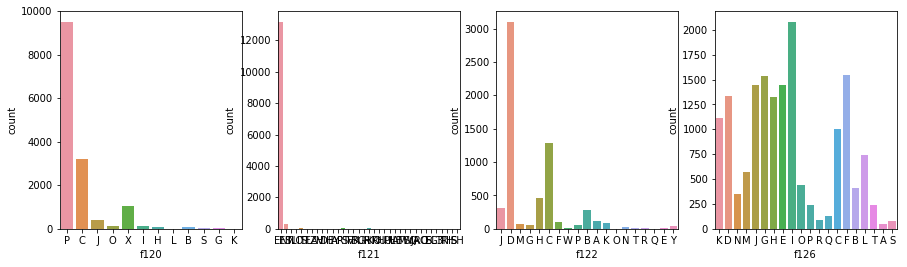

In [40]:
n_cols = 4
n_rows = 6
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(15, 4))
    for j in range(n_cols):
        sns.countplot(x=cat_cols[i*n_cols+j], data=train, ax=ax[j])

Violin plot for numerical features in a 31x4 grid.

/Users/jiawei/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


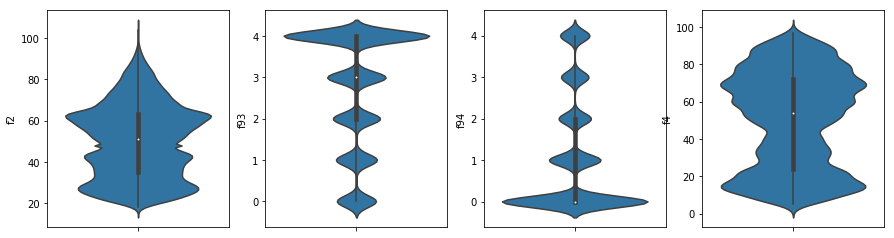

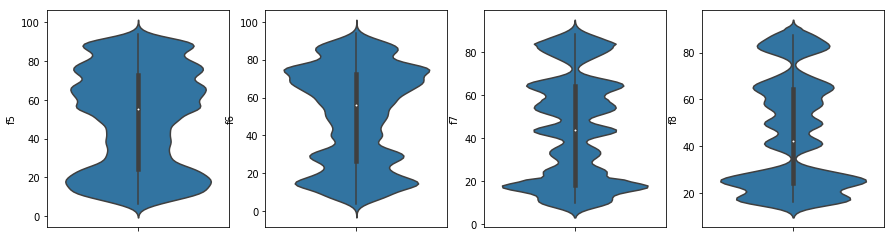

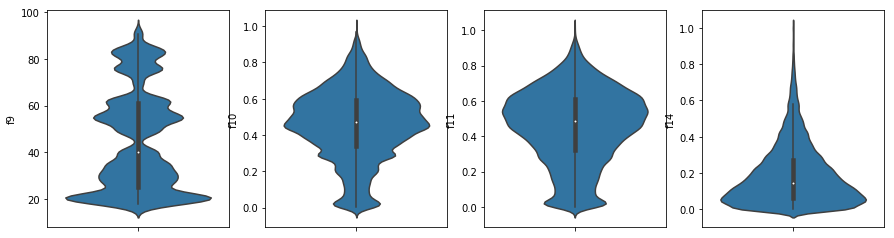

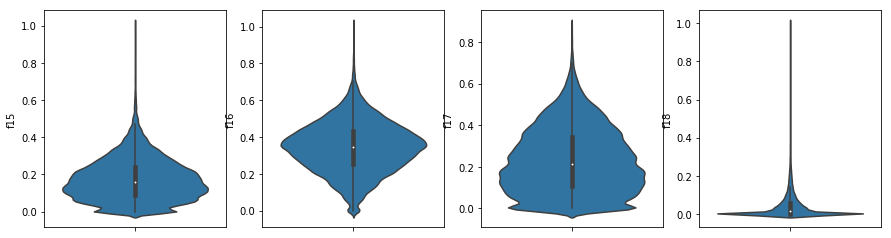

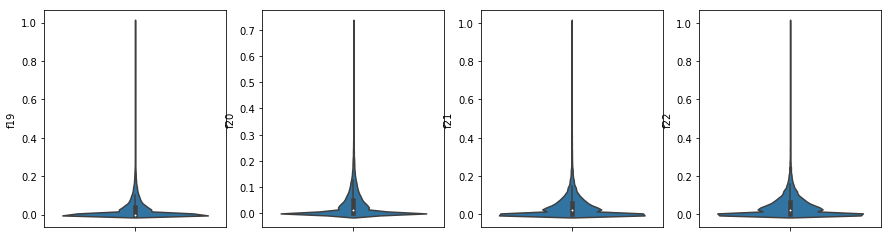

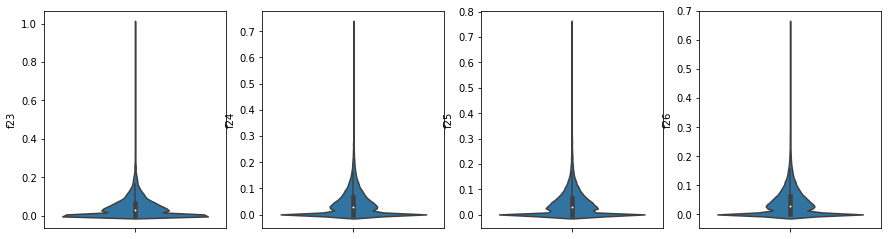

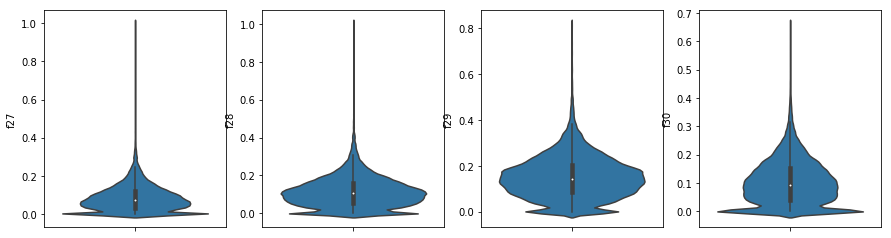

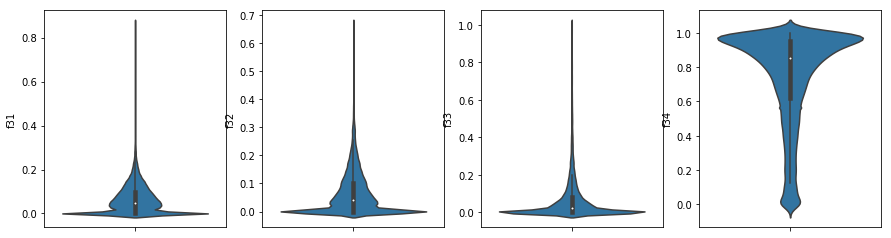

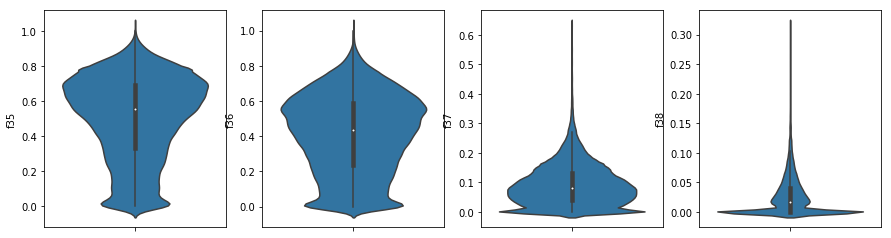

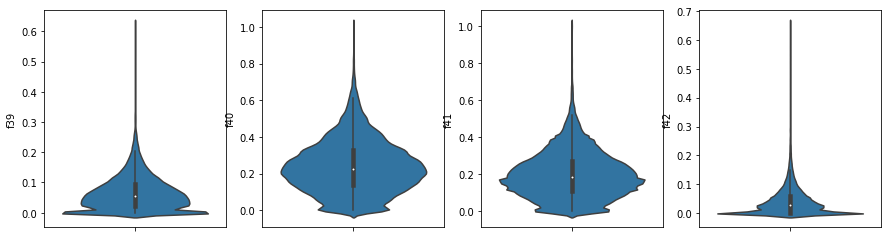

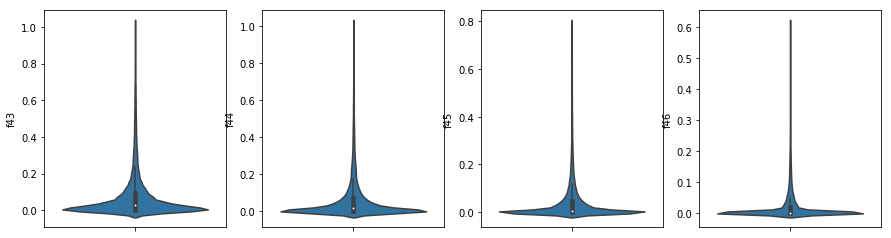

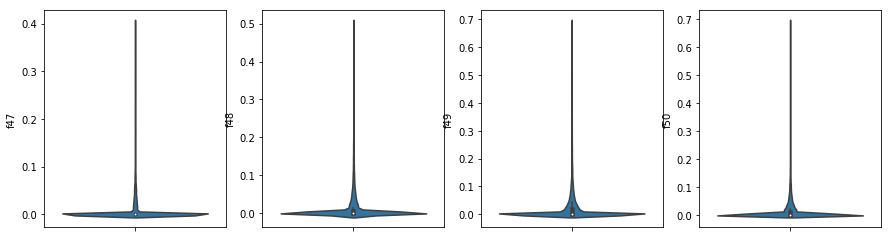

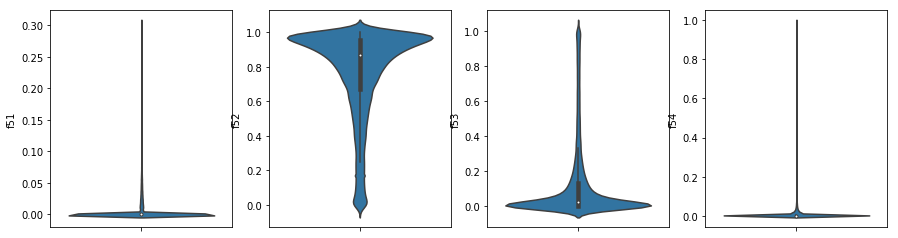

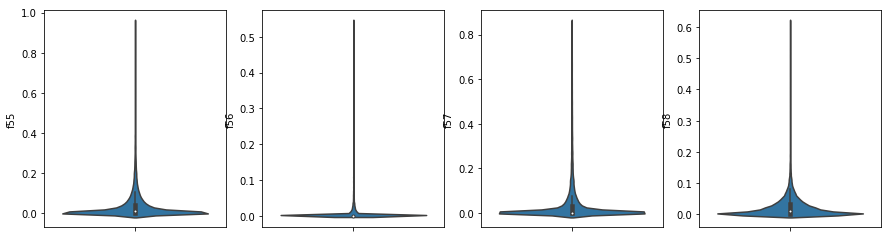

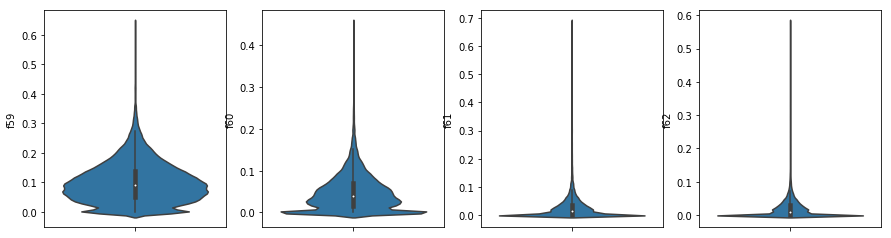

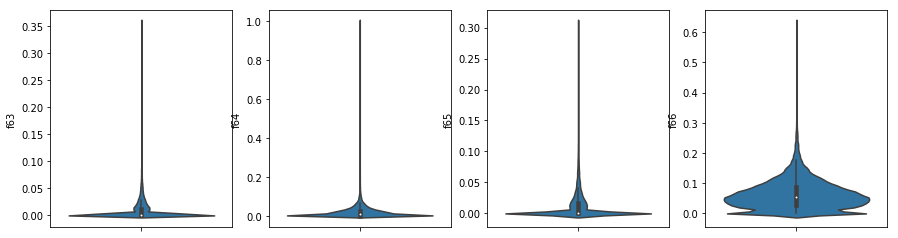

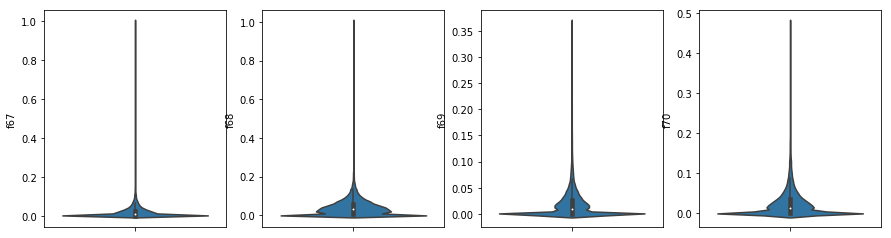

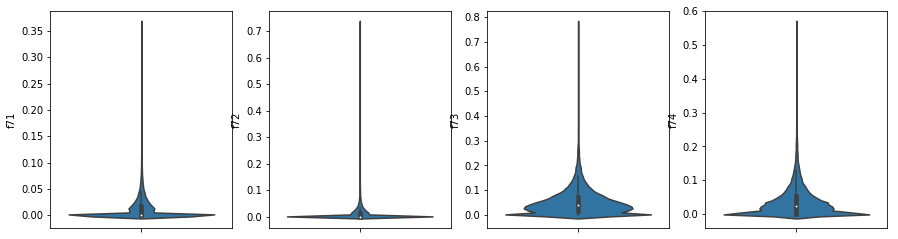

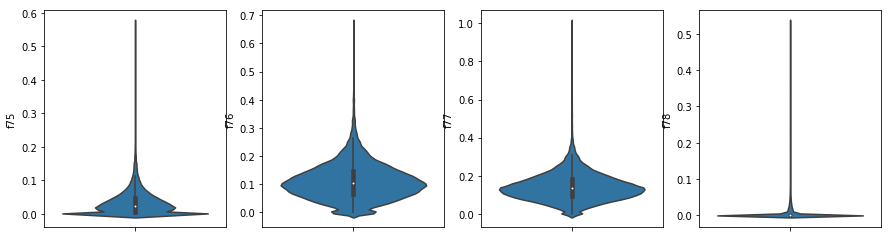

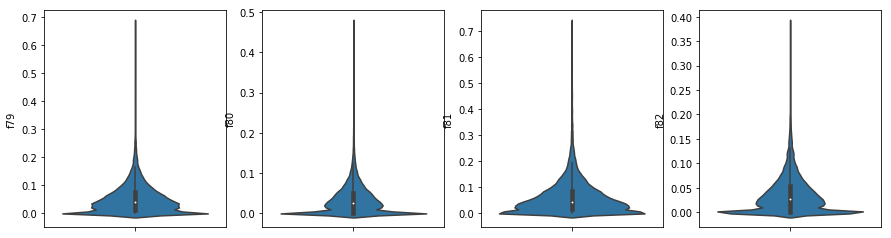

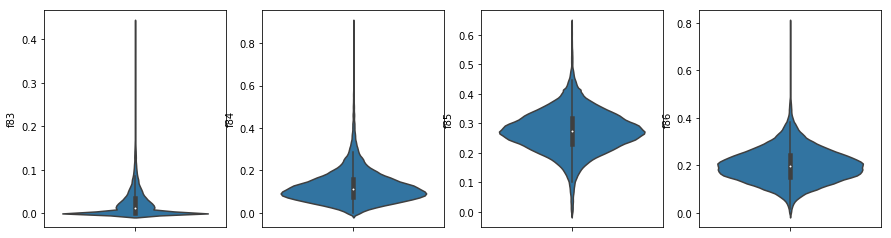

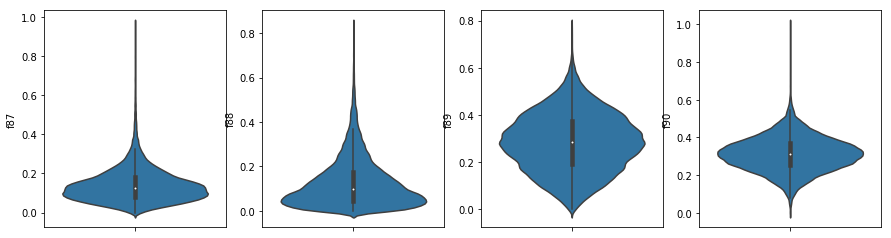

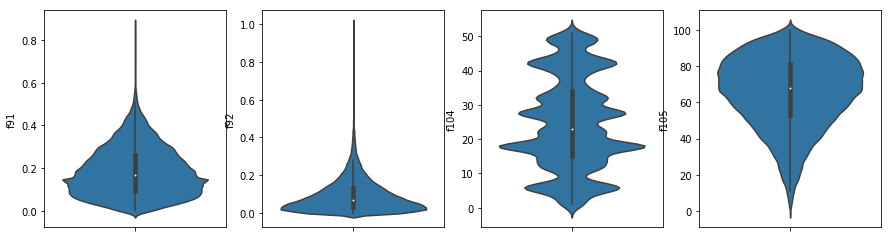

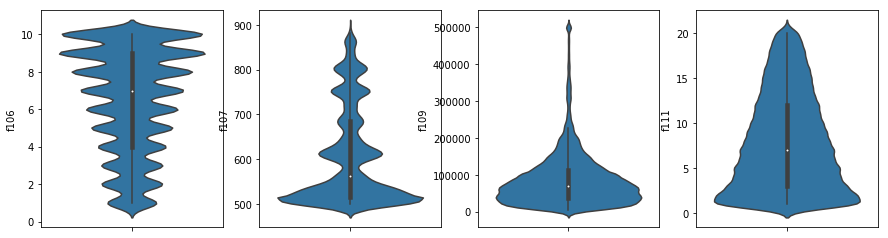

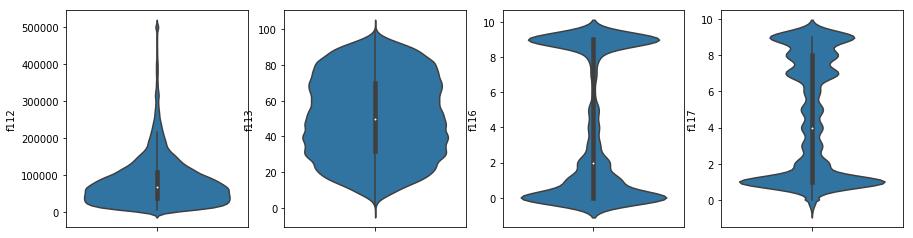

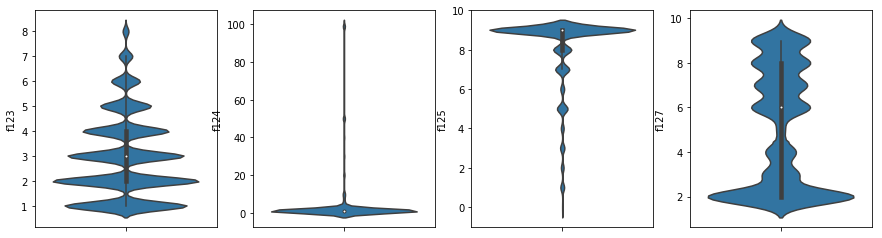

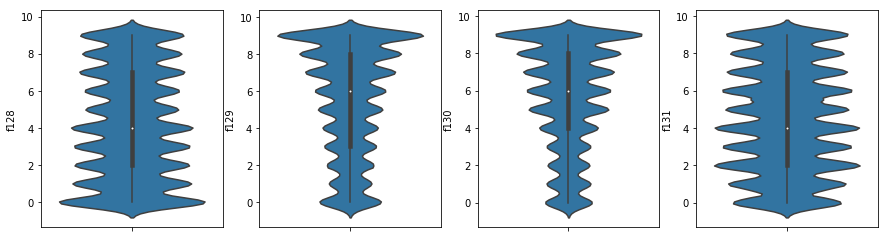

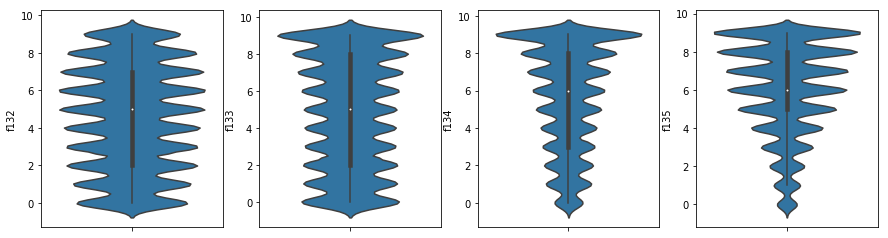

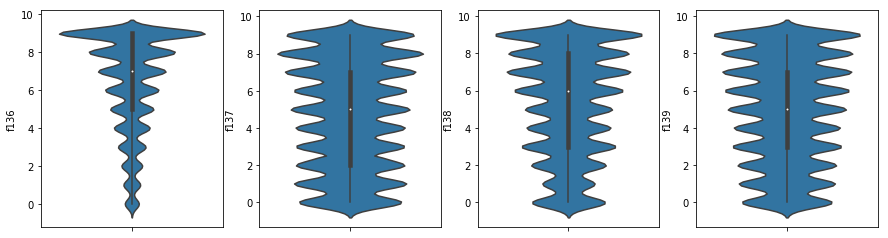

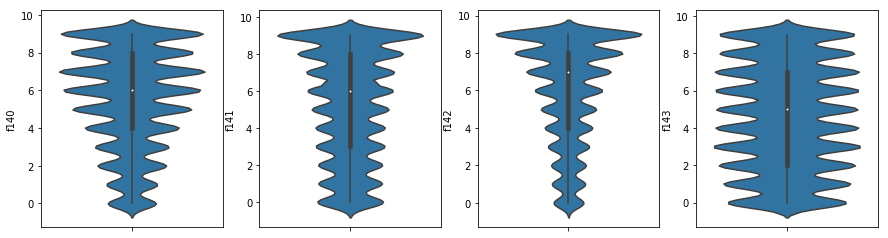

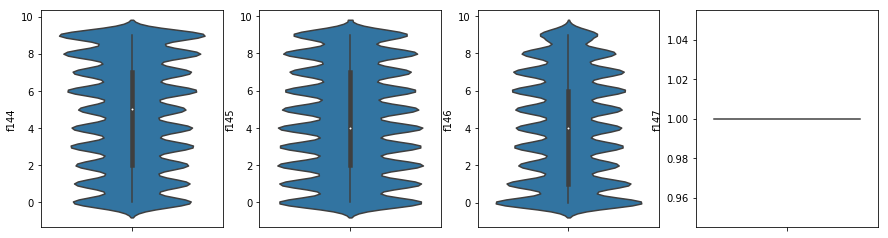

In [41]:
n_cols = 4
n_rows = 31

for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(15, 4))
    for j in range(n_cols):
        sns.violinplot(y=con_cols[i*n_cols+j], data=train, ax=ax[j])

<function matplotlib.pyplot.show>

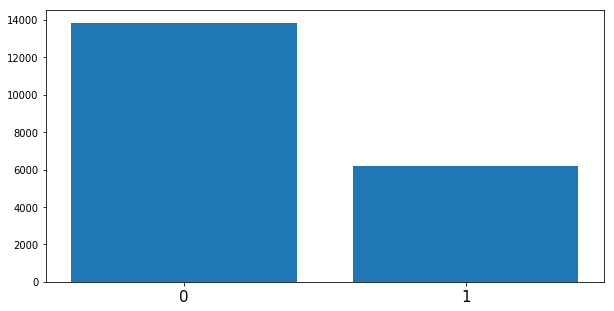

In [42]:
fig = plt.figure(figsize=(10,5))
plt.bar(train[target_col].value_counts().index, train[target_col].value_counts().values)
plt.xticks(train[target_col].value_counts().index, fontsize=15)
plt.show

In [43]:
train[target_col].value_counts()/train_size

0.0    0.69155
1.0    0.30845
Name: SPENDINGRESPONSE, dtype: float64

The SPENDINGRESPONSE ratio shows that in the train dataset there are 69% people believed "Spend to Improve Economy" and 31% chose "Reduce National Debt and Deficit". It is not a imbalanced problem. No special treatments are required. 

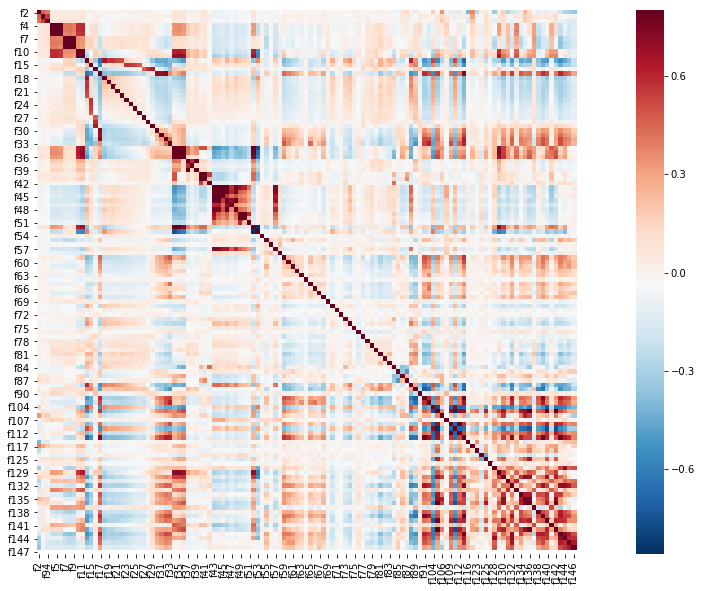

In [44]:
corrmat = train[con_cols].corr()
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="RdBu_r")
plt.show()

## Feature engineering 

### Missing values

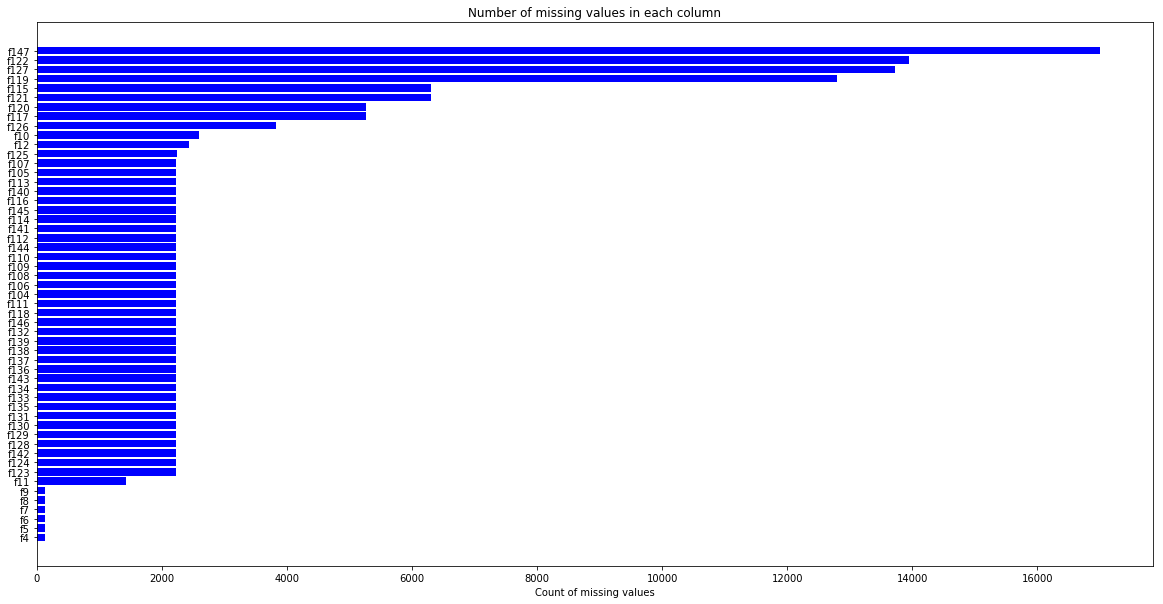

In [45]:
missing_df = train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>100]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(20,10))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

There are missing values in the training dataset. Since the features are anonymous and all encoded, no inpute of missing data will be treated. Missing data will be carried through the whole process.

### Catgorical features

#### High cardinality feature frequency encoding

In [46]:
freq_encod_cat = []
for i in cat_cols:
    if df_full[i].value_counts().size >= 35:
        freq_encod_cat.append(i)

In [47]:
freq_encod_cat

['State', 'f1', 'f115', 'f121']

In [48]:
con_freq_cols = []
for i in freq_encod_cat:
    freq_col_name = '%s_freq' % i
    freq_col = df_full.groupby(i).size().reset_index()
    freq_col.columns = [i, freq_col_name]
    df_full = pd.merge(df_full, freq_col, how = "left", on = i)
    df_full[freq_col.columns].head()
    cat_cols.remove(i)
    con_freq_cols.append(freq_col_name)

In [49]:
print(len(freq_encod_cat), len(con_freq_cols), len(cat_cols), len(con_cols))

4 4 20 124


In [50]:
df_full.head()

,ID,State,f1,f2,f3,f4,f5,f6,f7,f8,...,f143,f144,f145,f146,f147,SPENDINGRESPONSE,State_freq,f1_freq,f115_freq,f121_freq
0,3094,AK,AK01,69,E,61.0,55.33333,66.0,52.33333,49.25,...,7.0,4.0,1.0,1.0,NaN,1.0,72,72,NaN,NaN
1,13856,AK,AK01,59,M,61.0,55.33333,66.0,52.33333,49.25,...,7.0,8.0,4.0,4.0,NaN,1.0,72,72,7559.0,19311.0
2,16213,AK,AK01,63,D,61.0,55.33333,66.0,52.33333,49.25,...,2.0,6.0,1.0,1.0,NaN,0.0,72,72,7559.0,19311.0
3,17196,AK,AK01,55,D,61.0,55.33333,66.0,52.33333,49.25,...,6.0,6.0,3.0,2.0,NaN,0.0,72,72,7559.0,19311.0
4,17762,AK,AK01,75,D,61.0,55.33333,66.0,52.33333,49.25,...,3.0,3.0,0.0,0.0,NaN,0.0,72,72,583.0,19311.0


#### One Hot encoding

In [51]:
# Label encoding
LBL = preprocessing.LabelEncoder()
start = time.time()
LE_map = dict()
for cat_col in cat_cols:
    df_full[cat_col] = LBL.fit_transform(df_full[cat_col].astype(str))
    LE_map[cat_col]=dict(zip(LBL.classes_, LBL.transform(LBL.classes_)))
print ('Label enconding finished in %f seconds' % (time.time()-start))

Label enconding finished in 0.360796 seconds


In [52]:
OHE = preprocessing.OneHotEncoder(sparse=False)
start = time.time()
OHE.fit(df_full[cat_cols])
OHE_data = OHE.transform(df_full[cat_cols])
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))

OHE_vars = [var + '_' + str(level).replace(' ','_')\
                for var in cat_cols for level in LE_map[var]]

print (OHE_data.shape)


One-hot-encoding finished in 0.151612 seconds
(29231, 235)


In [53]:
df_full = pd.concat((df_full, pd.DataFrame(OHE_data,columns=OHE_vars)), axis = 1)

In [54]:
df_full.head()

,ID,State,f1,f2,f3,f4,f5,f6,f7,f8,...,f126_L,f126_M,f126_N,f126_O,f126_P,f126_Q,f126_R,f126_S,f126_T,f126_nan
0,3094,AK,AK01,69,4,61.0,55.33333,66.0,52.33333,49.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,13856,AK,AK01,59,12,61.0,55.33333,66.0,52.33333,49.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16213,AK,AK01,63,3,61.0,55.33333,66.0,52.33333,49.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17196,AK,AK01,55,3,61.0,55.33333,66.0,52.33333,49.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,17762,AK,AK01,75,3,61.0,55.33333,66.0,52.33333,49.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Numerical features

Apply box-cox transformations for skewed numeric features. First, calculate skewness of each numeric features:

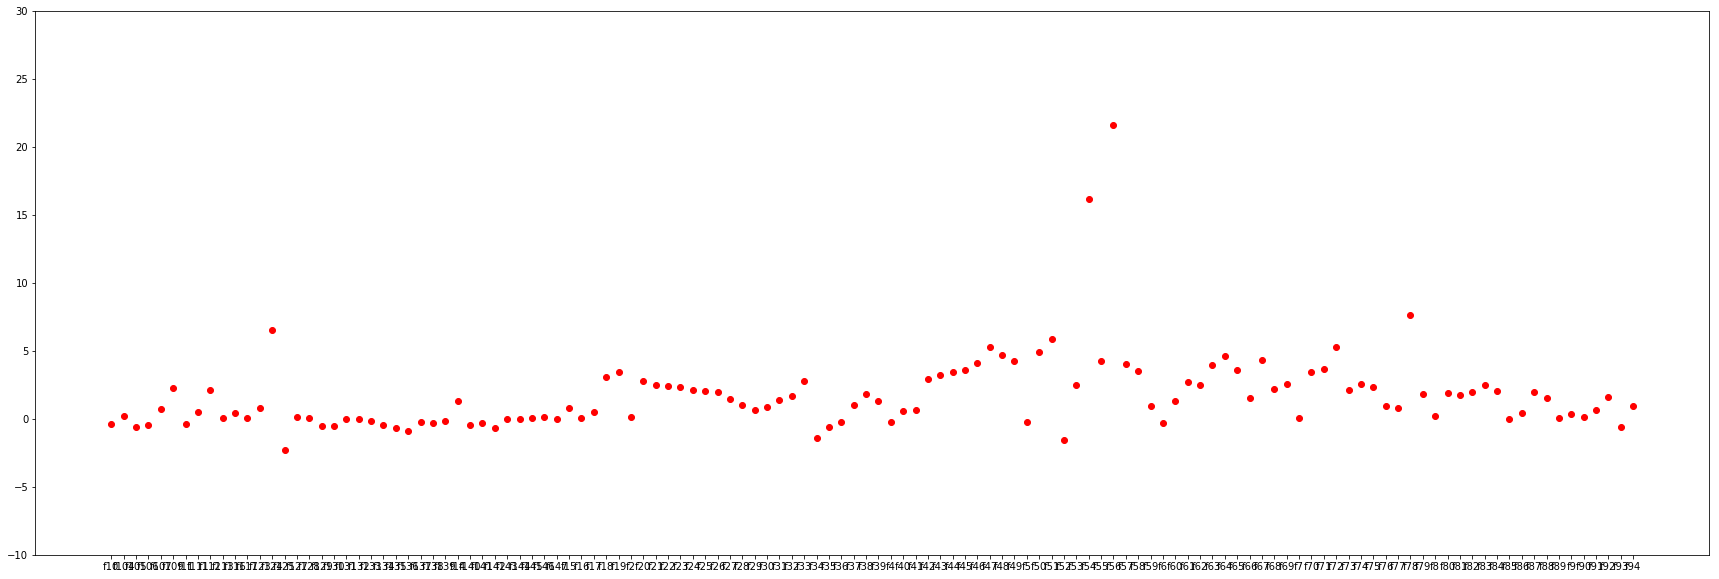

In [55]:
skewed_cols = df_full[con_cols].apply(lambda x: skew(x.dropna()))
fig = plt.figure(figsize=(30,10))
plt.plot(skewed_cols,'ro')
plt.ylim((-10,30))
plt.show()

In [56]:
large_skewed_cols = skewed_cols[abs(skewed_cols) > 0.25].index.values
for skewed_col in large_skewed_cols:
    not_null_mask = ~df_full[skewed_col].isnull()
    transformed, lam = boxcox(df_full.loc[not_null_mask, skewed_col] + 1)
    df_full.loc[not_null_mask, skewed_col] = transformed

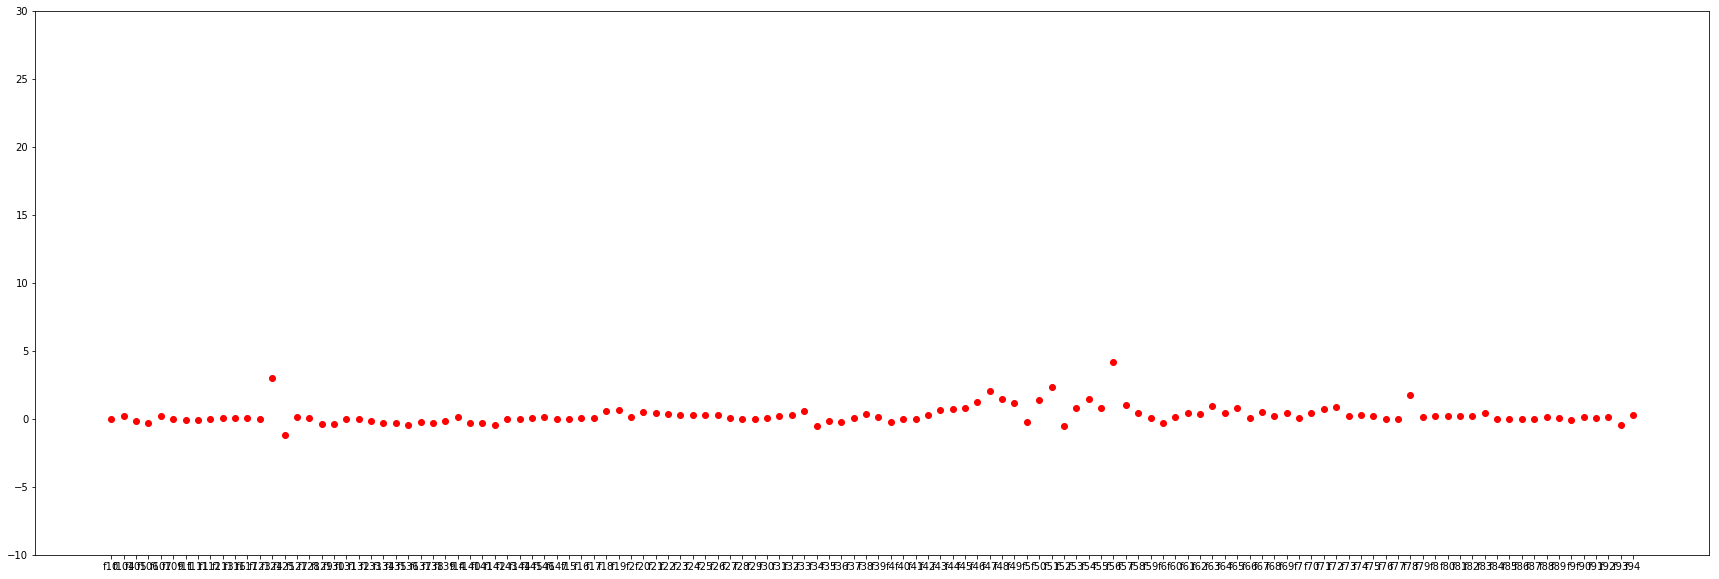

In [57]:
skewed_cols = df_full[con_cols].apply(lambda x: skew(x.dropna()))
fig = plt.figure(figsize=(30,10))
plt.plot(skewed_cols,'ro')
plt.ylim((-10,30))
plt.show()

In [58]:
cols = [id_col] + OHE_vars + con_cols + con_freq_cols + [target_col]
len(cols)

365

Save the pre-processed data. 

In [59]:
df_full[cols].to_csv('../data/input_proc2.csv', index=False)